# 溫度分布-小時溫度觀測分析格點資料分析 313652018

## 0.資料可視化
先把xml資料讀出，畫熱圖(120*67)

In [1]:
import re, math, numpy as np
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

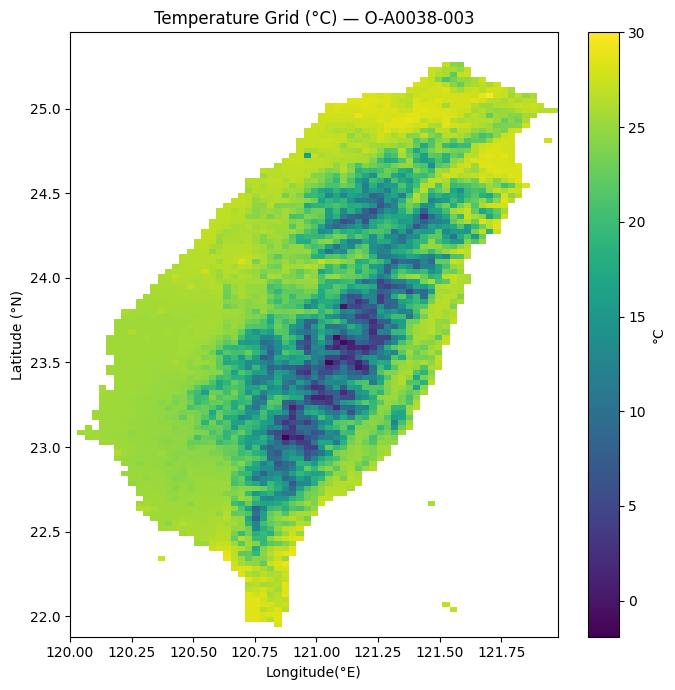

In [2]:
xml_path="O-A0038-003.xml"
save_pig="O-A0038-003_heatMap.png"

text=Path(xml_path).read_text(encoding='utf-8', errors='ignore')
m=re.search(r"<Content>(.*?)</Content>", text, flags=re.DOTALL)
content = m.group(1)

tokens = re.findall(r"[-+]?\d+(?:\.\d+)?(?:[eE][-+]?\d+)?", content)
arr = np.array([float(t) for t in tokens], dtype = float)

H, W = 120, 67 #緯度120 經度67
grid = arr.reshape(H,W)
grid[grid == -999.0] = np.nan

lon0, lat0,d = 120.00, 21.88, 0.03
lons = lon0 + d*np.arange(W) #67
lats = lat0 + d*np.arange(H) #120

plt.figure(figsize=(7,7))
extent = [lons.min(), lons.max(), lats.min(), lats.max()]
im = plt.imshow(grid, origin = "lower", extent=extent, aspect="auto")
plt.xlabel("Longitude(°E)")
plt.ylabel("Latitude (°N)")
plt.title("Temperature Grid (°C) — O-A0038-003")
plt.colorbar(im, label="°C")
plt.tight_layout()
plt.savefig(save_pig, dpi=200)
plt.show()


## Problem 1.
將原始資料轉換為兩個監督式學習資料集：  
  
a. 分類 (Classification) 資料集
* 格式：(精度, 緯度, label)
* 規則：
    * 若溫度觀測值為 無效值 -999，則 label = 0。
    * 若溫度觀測值為 有效值，則 label = 1。
b. 回歸 (Regression) 資料集  
* 格式：(精度, 緯度, Value)
* 規則：
  * 僅保留有效的溫度觀測值（剔除所有 -999.）。
  * value 為對應的攝氏溫度。

In [3]:
OUT_CLS  = "classification_dataset.csv"
OUT_REG  = "regression_dataset.csv"

W_LON = 67  #緯度
H_LAT = 120 #經度
lon0, lat0, d=120.00, 21.88, 0.03 #起點 解析度

vals = np.array([float(t) for t in tokens], dtype=float)
grid = vals.reshape(H_LAT, W_LON)
lons=lon0+d*np.arange(W_LON)
lats=lat0+d*np.arange(H_LAT)
LAT, LON = np.meshgrid(lats, lons, indexing="ij") #shape=(120,67)

#----------
#### Classification dataset

label = np.where(grid == -999.0, 0, 1).astype(int)
df_cls = pd.DataFrame({
    "lon": LON.ravel(),
    "lat": LAT.ravel(),
    "label": label.ravel()
})
df_cls.to_csv(OUT_CLS, index=False)
print(f"Saved: {OUT_CLS} | rows={len(df_cls)}, positives={df_cls['label'].sum()}, negatives={(df_cls['label']==0).sum()}")

#----------
#### Classification dataset

mask = grid != -999.0
df_reg = pd.DataFrame({
    "lon": LON[mask],
    "lat": LAT[mask],
    "value": grid[mask]
})
df_reg.to_csv(OUT_REG, index=False)

#-----------
print(f"Saved: {OUT_REG} | rows={len(df_reg)}, min={df_reg['value'].min():.2f}, max={df_reg['value'].max():.2f}, mean={df_reg['value'].mean():.2f}")



Saved: classification_dataset.csv | rows=8040, positives=3495, negatives=4545
Saved: regression_dataset.csv | rows=3495, min=-1.90, max=30.00, mean=21.59


## Problem 2. 模型訓練
使用 Problem 1. 中整理出的兩個資料集，分別訓練一個簡單的機器學習模型：

* 分類模型 (classification model)：
    * 以 (精度, 緯度) 預測格點資料是否為有效值 (0 或 1)。

* 回歸模型 (regression model)：
    * 以 (精度, 緯度) 預測對應的溫度觀測值。

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error


### 2.(a) 分類模型

In [5]:
df_cls = pd.read_csv("classification_dataset.csv")
X_cls = df_cls[["lon", "lat"]]
y_cls = df_cls["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state = 42, stratify = y_cls
)

clf = LogisticRegression(max_iter = 1000)   ## logistic regression
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("=== Claddification Model => Logistic Regression ===")
print(classification_report(y_test, y_pred, digits=3))
print("混淆矩陣：\n", confusion_matrix(y_test, y_pred))


=== Claddification Model => Logistic Regression ===
              precision    recall  f1-score   support

           0      0.565     1.000     0.722       909
           1      0.000     0.000     0.000       699

    accuracy                          0.565      1608
   macro avg      0.283     0.500     0.361      1608
weighted avg      0.320     0.565     0.408      1608

混淆矩陣：
 [[909   0]
 [699   0]]


c:\Users\user\.conda\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\.conda\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\.conda\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Logistic Regression在這邊好像表現不太好，所以下面用random forest看看

In [6]:
df_cls = pd.read_csv("classification_dataset.csv")
X_cls = df_cls[["lon", "lat"]]
y_cls = df_cls["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state = 42, stratify = y_cls
)

clf = RandomForestClassifier(n_estimators=100, random_state=42) ##random forest
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("=== Claddification Model => Random Forest ===")
print(classification_report(y_test, y_pred, digits=3))
print("混淆矩陣：\n", confusion_matrix(y_test, y_pred))


=== Claddification Model => Random Forest ===
              precision    recall  f1-score   support

           0      0.990     0.991     0.991       909
           1      0.989     0.987     0.988       699

    accuracy                          0.989      1608
   macro avg      0.989     0.989     0.989      1608
weighted avg      0.989     0.989     0.989      1608

混淆矩陣：
 [[901   8]
 [  9 690]]


分類模型結果比較  
**Logistic Regression**

* Accuracy：0.565
* 觀察：
  * 模型將所有樣本預測為「無效」(label=0)，導致 class 1 完全無法辨識。
  * 在混淆矩陣中，所有 699 個有效點 (label=1) 都被錯分為 0。
  * 線性模型無法捕捉複雜的「島內 vs 海上」分佈邊界，因此效果不佳。
  
**Random Forest**
* Accuracy：0.989
* 觀察：
  * precision、recall、f1-score 在兩個類別上幾乎都達到 0.99。
  * 混淆矩陣顯示只有少數點被錯分（8 個無效點、9 個有效點）。
  * Random Forest 能處理非線性邊界，適合用來學習地理空間資料的複雜分佈。

### 2.(b) 回歸模型

In [7]:
df_reg = pd.read_csv("regression_dataset.csv")
X_reg = df_reg[["lon", "lat"]]
y_reg = df_reg["value"]
X_train, X_test, y_train, y_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state = 42
)

reg = LinearRegression()   # 先用linear regression
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print("\n=== Regression Model => Linear Regression ===")
print("MAE:", mean_absolute_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)  
rmse = np.sqrt(mse)                       
print("RMSE:", rmse)



=== Regression Model => Linear Regression ===
MAE: 4.398637237716326
RMSE: 5.669482982484731


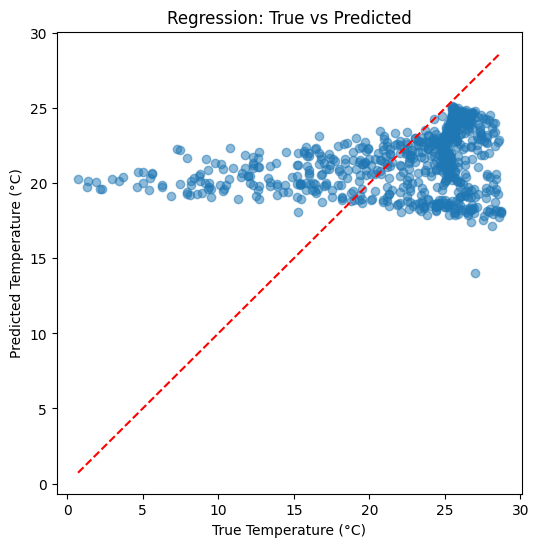

In [8]:
# --- Visualization ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Regression: True vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

確實如果只針對**經緯度**做各個地區**溫度預測**的話，資料特徵太簡單了，以至於無法用linear regression做預測。所以下面試試看各種非線性方法，包括：random forest, KNN regressor, SVR

### 2.b - Random forest

In [9]:
df = pd.read_csv("regression_dataset.csv")
X = df[["lon","lat"]].values
y = df["value"].values

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_tr, y_tr)
pred = rf.predict(X_te)

mae = mean_absolute_error(y_te, pred)
mse = mean_squared_error(y_test, y_pred)  
rmse = np.sqrt(mse)                       
print(f"RF  MAE={mae:.3f}  RMSE={rmse:.3f}")

RF  MAE=1.517  RMSE=5.669


### 2.b - KNN

In [10]:
from sklearn.neighbors import KNeighborsRegressor
best = None
for k in [3,5,7,9,15,25]:
    knn = KNeighborsRegressor(n_neighbors=k, weights="distance")
    knn.fit(X_tr, y_tr)
    p = knn.predict(X_te)
    mse = mean_squared_error(y_test, y_pred)  
    rmse = np.sqrt(mse)  
    if best is None or rmse < best[0]:
        best = (rmse, k)
print("Best K:", best)

knn = KNeighborsRegressor(n_neighbors=best[1], weights="distance")
knn.fit(X_tr, y_tr)
p = knn.predict(X_te)
print(f"KNN MAE={mean_absolute_error(y_te,p):.3f}  RMSE={rmse:.3f}")


Best K: (np.float64(5.669482982484731), 3)
KNN MAE=1.403  RMSE=5.669


### 2.b - SVR

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR


svr = make_pipeline(
    StandardScaler(),
    SVR(kernel="rbf", C=10.0, gamma="scale", epsilon=0.2)
)
svr.fit(X_tr, y_tr)
p = svr.predict(X_te)
mse = mean_squared_error(y_test, y_pred)  
rmse = np.sqrt(mse)                 
print(f"SVR MAE={mean_absolute_error(y_te,p):.3f}  RMSE={rmse:.3f}")


SVR MAE=2.170  RMSE=5.669


※ 為了確認程式能完整執行，本檔案在最終提交前重新執行（重跑）一次。由於模型訓練過程包含隨機初始化與資料抽樣，最終的訓練與測試結果可能與先前版本略有不同，但不影響整體結論與分析方向。